<a href="https://colab.research.google.com/github/akaver/NLP2019/blob/master/Lab15_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention

This lab demonstrates how to use the attebtion mechansim.

While usually attention is used in the encoder-decoder architecture, attention can be also used for sequence classification.

In essence, attention is just a way to use a dynamically weighted sum instead of max or average pooling when reducing features over a sequence to a fixed dimension.

We will use the same accent identification example as last week.

In [0]:
!rm -f accent_subset_wav.zip
!wget https://phon.ioc.ee/~tanela/accent_subset_wav.zip

--2019-05-07 08:13:41--  https://phon.ioc.ee/~tanela/accent_subset_wav.zip
Resolving phon.ioc.ee (phon.ioc.ee)... 193.40.251.126
Connecting to phon.ioc.ee (phon.ioc.ee)|193.40.251.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503722423 (480M) [application/zip]
Saving to: ‘accent_subset_wav.zip’

accent_subset_wav.z 100%[===================>] 480.39M  71.0MB/s    in 11s     

2019-05-07 08:13:52 (44.1 MB/s) - ‘accent_subset_wav.zip’ saved [503722423/503722423]



In [0]:
! rm -rf data
! mkdir -p data
! unzip -q accent_subset_wav.zip -d data

In [0]:
! rm -f accent_trainset.txt accent_devset.txt
! wget -q  https://phon.ioc.ee/~tanela/tmp/accent_trainset.txt https://phon.ioc.ee/~tanela/tmp/accent_devset.txt

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
! pip install python_speech_features

  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
from python_speech_features import logfbank, mfcc
import scipy.io.wavfile as wav

In [0]:
class AccentDataset(Dataset):
    def __init__(self, ids_file, root_dir):
               
        self.data = []
        ids = [l.strip() for l in open(ids_file).readlines()]
        for i, id in enumerate(ids):
          print("\rReading %d-th file" % i, end="")
          language_id = 0  
          if id.startswith("english"):
            language_id = 1
          elif id.startswith("mandarin"):
            language_id = 2
          (rate,audio) = wav.read("data/%s.wav" % id)
          assert rate == 16000
          # we use only the first 1000 feature vectors, i-e., the 1st 10 seconds of the audio         
          features = logfbank(audio, 16000)[0:1000]
          feat_tensor = torch.FloatTensor(features)
          # each member in the dataset is a tuple of (features, language_id)
          self.data.append((feat_tensor, language_id, id))
      
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [0]:
train_dataset = AccentDataset("accent_trainset.txt", root_dir="data")

Reading 675-th file

In [0]:
dev_dataset = AccentDataset("accent_devset.txt", root_dir="data")

Reading 69-th file

In [0]:
train_dataset[0][0].shape

torch.Size([1000, 26])

In [0]:
train_iter = DataLoader(train_dataset, batch_size=32,  shuffle=True)
dev_iter = DataLoader(dev_dataset, batch_size=32,  shuffle=False)


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import sys

In [0]:
class ResidualBlock(nn.Module):

    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(dim)
        

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # add the original input and the transformed input together
        out += residual
        out = self.relu(out)

        return out

Our baseline model is based on convolutional layers with residual connections.

In [0]:
class AccentResNet(nn.Module):
  
  def __init__(self, num_classes, feature_dim, dropout_prob=0.2):
    super(AccentResNet, self).__init__()
    self.layers = nn.Sequential(
        # First, apply a simple Convnet to raw input
        nn.BatchNorm1d(feature_dim),
        nn.Conv1d(feature_dim, 32, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        
        # Now, apply the first residual block
        ResidualBlock(32),
        
        # Just increase the number of filters using a a convolution with kernel size 1
        nn.Conv1d(32, 48, kernel_size=1, stride=1),
        # And compress the signmal in time
        nn.MaxPool1d(kernel_size=2),
        
        # Now, apply the second residual block
        ResidualBlock(48),

        nn.Conv1d(48, 64, kernel_size=1, stride=1),
        nn.MaxPool1d(kernel_size=2),
        
        # Now, apply the third residual block
        ResidualBlock(64),        
    )
    
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(64, num_classes)
    
  def forward(self, x):
    # Conv1d takes in (batch, channels, seq_len), but raw signal is (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()
    x = self.layers(x)
  
    
    # global max
    x = F.avg_pool1d(x, x.size(2))
    #print(x.shape)
    x = x.view(-1, 64)
    #print(x.shape)
    x = self.dropout(x) 
    logit = self.fc(x)
    return logit

In [0]:
def train(model, num_epochs, train_iter, test_iter, device,  label_smoothing=0.1, lr_decay=0.5):

  assert (label_smoothing >= 0.0 and label_smoothing <= 1.0)
  
  # Each non-target class gets a target probability of label_smoothing / 2.0
  non_target_prob = label_smoothing / 2.0
  
  # Usually, SGD is used instead of Adam, when learning rate scheduling is used
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  
  # every 2 epochs, we will multiply the learning rate by 0.5
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=lr_decay)

  steps = 0
  best_acc = 0
  last_step = 0
  
  criterion = nn.KLDivLoss(reduction='sum')
  
  for epoch in range(1, num_epochs+1):
    lr_scheduler.step()
    print("Starting epoch %d, learning rate is %f" % (epoch, lr_scheduler.get_lr()[0]))
    for batch in train_iter:
      # set training mode
      model.train()
      fbank, target, file_id = batch
      fbank, target = fbank.to(device), target.to(device)
      batch_size = target.shape[0]
      
      # Create a one-hot encoded target matrix of size (batch_size, 3)
      # where the values corresponding to correct labelsa re 1.0-label_smoothing
      # and everywhere else there is non_target_prob (equal to 0.05, if label_smoothing is 0.1)
      target_one_hot = torch.ones(batch_size, 3).to(device)      
      target_one_hot *= non_target_prob
      target_one_hot[torch.arange(batch_size, dtype=torch.int64).to(device), target] = 1.0 - label_smoothing
      

      optimizer.zero_grad()
      logit = model(fbank)
      log_probabilities = F.log_softmax(logit)
      loss = criterion(log_probabilities, target_one_hot).mean()
      loss.backward()
      optimizer.step()

    train_acc = evaluate("train", train_iter, model)                
    dev_acc = evaluate("dev", dev_iter, model)       

def evaluate(name, data_iter, model):
  # set evaluation mode (turns off dropout)
  model.eval()
  corrects, avg_loss = 0, 0
  for batch in data_iter:
    fbank, target, file_id = batch
    fbank, target = fbank.to(device), target.to(device)
    
    logit = model(fbank)
    loss = F.cross_entropy(logit, target,  reduction='sum')

    avg_loss += loss.item()
    corrects += (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()

  size = len(data_iter.dataset)
  avg_loss /= size
  accuracy = 100.0 * float(corrects)/size
  print('  Evaluation on {} - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(name,
                                                                        avg_loss, 
                                                                        accuracy, 
                                                                        corrects, 
                                                                        size))
  return accuracy, avg_loss

In [0]:
model_resnet = AccentResNet(3, train_dataset[0][0].shape[1]).to(device)
train(model_resnet, 30, train_iter, dev_iter, device=device, label_smoothing=0.1, lr_decay=0.9)

Starting epoch 1, learning rate is 0.008100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


  Evaluation on train - loss: 0.812526  acc: 77.2189%(522/676)
  Evaluation on dev - loss: 0.771873  acc: 81.4286%(57/70)
Starting epoch 2, learning rate is 0.007290
  Evaluation on train - loss: 0.629996  acc: 77.6627%(525/676)
  Evaluation on dev - loss: 0.533382  acc: 81.4286%(57/70)
Starting epoch 3, learning rate is 0.006561
  Evaluation on train - loss: 0.593155  acc: 77.3669%(523/676)
  Evaluation on dev - loss: 0.525966  acc: 81.4286%(57/70)
Starting epoch 4, learning rate is 0.005905
  Evaluation on train - loss: 0.575088  acc: 77.9586%(527/676)
  Evaluation on dev - loss: 0.511040  acc: 81.4286%(57/70)
Starting epoch 5, learning rate is 0.005314
  Evaluation on train - loss: 0.534542  acc: 80.6213%(545/676)
  Evaluation on dev - loss: 0.429641  acc: 84.2857%(59/70)
Starting epoch 6, learning rate is 0.004783
  Evaluation on train - loss: 0.547220  acc: 78.6982%(532/676)
  Evaluation on dev - loss: 0.452728  acc: 85.7143%(60/70)
Starting epoch 7, learning rate is 0.004305
  Ev

Now, let's define our model with attention. 

In [0]:
class AccentResNetAttention(nn.Module):
  
  def __init__(self, num_classes, feature_dim, attention_size=32,  dropout_prob=0.2):
    super(AccentResNetAttention, self).__init__()
    
    # Utterance-level attention network
    # Transforms outputs of convolutional layers to the same dim as the sentence context vector
    self.utterance_attention = nn.Linear(64, attention_size)
    
    # Utterance context vector to take dot-product with    
    self.utterance_context_vector = nn.Linear(attention_size, 1, bias=False) 
    
    self.layers = nn.Sequential(
        # First, apply a simple Convnet to raw input
        nn.BatchNorm1d(feature_dim),
        nn.Conv1d(feature_dim, 32, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        
        # Now, apply the first residual block
        ResidualBlock(32),
        
        # Just increase the number of filters using a a convolution with kernel size 1
        nn.Conv1d(32, 48, kernel_size=1, stride=1),
        # And compress the signmal in time
        nn.MaxPool1d(kernel_size=2),
        
        # Now, apply the second residual block
        ResidualBlock(48),

        nn.Conv1d(48, 64, kernel_size=1, stride=1),
        nn.MaxPool1d(kernel_size=2),
        
        # Now, apply the third residual block
        ResidualBlock(64),        
    )
    
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(64, num_classes)

  # We extracted the method that calculates output from the residual layers and the 
  # attention weights to a seperate method, so that we can call it independantly later.
  def compute_layers_and_attention_scores(self, x):
    # Conv1d takes in (batch, features, seq_len), but raw signal is (batch, seq_len, features)
    x = x.permute(0, 2, 1).contiguous()
    # Compute the output of the main layers
    x = self.layers(x)
  
    # Convert it back to shape (batch, features, seq_len)
    x = x.permute(0, 2, 1).contiguous()
    
    # Pass the outputs through a mini NN sentence_attention with tanh non-linearity 
    att_s = self.utterance_attention(x) 
    att_s = torch.tanh(att_s)
        
    # Take the dot-product of the attention vectors with the context vector (i.e. parameters of linear layer)
    att_s = self.utterance_context_vector(att_s)
    
    # normalize the attention scores per each utterance in the batch
    att_s = F.softmax(att_s, dim=1)
    
    return x, att_s
    
    
  def forward(self, x):
    x, att_s = self.compute_layers_and_attention_scores(x)
    # take a weighted sum of sequence-level outputs, using attentions scores as weights
    x = (x * att_s).sum(dim=1)
    x = x.view(-1, 64)
    x = self.dropout(x) 
    logit = self.fc(x)
    return logit

In [0]:
model_resnet_att = AccentResNetAttention(3, train_dataset[0][0].shape[1]).to(device)
model_resnet_att.forward(next(iter(dev_iter))[0].to(device))

tensor([[-2.8745e-01,  1.1832e-01,  1.5519e-01],
        [-1.9342e-01, -2.4652e-01,  1.1101e-01],
        [-2.8120e-01,  1.3447e-01,  1.9262e-01],
        [-2.9317e-01,  1.7695e-01,  3.7803e-02],
        [-1.6700e-01, -9.0139e-02,  1.5290e-01],
        [-3.9256e-02, -1.8163e-01,  3.1026e-01],
        [-3.7852e-01, -4.2756e-02,  3.5708e-01],
        [-1.6676e-01, -8.6806e-02,  1.1187e-01],
        [-2.7828e-01,  2.9870e-02,  9.2107e-02],
        [-1.4780e-01, -2.3245e-03,  3.5505e-01],
        [-1.2198e-01,  9.2777e-02, -8.8222e-03],
        [-2.9247e-01, -5.5414e-02,  1.3911e-01],
        [-3.3919e-03, -2.2697e-01,  2.3052e-01],
        [-1.7976e-01, -1.0145e-01,  2.3548e-01],
        [-2.6348e-01, -1.0109e-01,  1.3408e-01],
        [-2.6923e-02, -1.3397e-01,  1.5507e-01],
        [-1.7540e-01, -8.2150e-02,  2.3231e-01],
        [-3.5304e-01,  1.9399e-02,  1.4484e-02],
        [-2.5792e-01, -1.2372e-01,  1.0249e-01],
        [-2.7977e-01, -2.5441e-01,  1.9926e-01],
        [-1.9820e-01

In [0]:
model_resnet_attention = AccentResNetAttention(3, train_dataset[0][0].shape[1], attention_size=32).to(device)
train(model_resnet_attention, 30, train_iter, dev_iter, device=device, label_smoothing=0.1, lr_decay=0.95)

Starting epoch 1, learning rate is 0.009025


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


  Evaluation on train - loss: 0.828065  acc: 77.2189%(522/676)
  Evaluation on dev - loss: 0.784200  acc: 81.4286%(57/70)
Starting epoch 2, learning rate is 0.008574
  Evaluation on train - loss: 0.761098  acc: 78.9941%(534/676)
  Evaluation on dev - loss: 0.723768  acc: 80.0000%(56/70)
Starting epoch 3, learning rate is 0.008145
  Evaluation on train - loss: 0.636491  acc: 77.2189%(522/676)
  Evaluation on dev - loss: 0.554783  acc: 81.4286%(57/70)
Starting epoch 4, learning rate is 0.007738
  Evaluation on train - loss: 0.699121  acc: 80.9172%(547/676)
  Evaluation on dev - loss: 0.693016  acc: 80.0000%(56/70)
Starting epoch 5, learning rate is 0.007351
  Evaluation on train - loss: 0.528379  acc: 78.2544%(529/676)
  Evaluation on dev - loss: 0.532291  acc: 81.4286%(57/70)
Starting epoch 6, learning rate is 0.006983
  Evaluation on train - loss: 0.553850  acc: 77.6627%(525/676)
  Evaluation on dev - loss: 0.495225  acc: 81.4286%(57/70)
Starting epoch 7, learning rate is 0.006634
  Ev

Now, let's try to visialize the attention weights on a sample audio deom the dev set.

In [0]:
dev_i = 1

In [0]:
dev_dataset[dev_i]

(tensor([[-5.1605, -5.5195, -4.2035,  ...,  2.4754,  2.4821,  2.6672],
         [-1.7669, -1.4730, -1.4696,  ...,  2.7946,  2.4887,  2.9715],
         [ 1.1526,  2.4573,  1.9654,  ...,  4.2600,  4.6491,  4.4816],
         ...,
         [ 6.4875,  7.4449,  8.0634,  ...,  9.5870, 10.1051,  9.8569],
         [ 5.6047,  7.5083,  7.1632,  ...,  9.7765, 10.0478,  9.5710],
         [ 5.5727,  7.3456,  7.4159,  ...,  9.7045,  9.5492,  8.7940]]),
 2,
 'mandarin11')

In [0]:
# Compute output from resnet and the ettention weights
x, att_s = model_resnet_attention.compute_layers_and_attention_scores(dev_dataset[dev_i][0].reshape(1, dev_dataset[dev_i][0].shape[0], -1).to(device))

In [0]:
att_s.shape

torch.Size([1, 249, 1])

In [0]:
# Attention weights must sum to 1
# Compute output from resnet and the ettention weights
x, att_s = model_resnet_attention.compute_layers_and_attention_scores(dev_dataset[dev_i][0].reshape(1, dev_dataset[dev_i][0].shape[0], -1).to(device))

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

Now, let's visualize the audio file, filterbank features, output from the convolutions and the attention weights.

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import IPython.display as ipd
import numpy as np

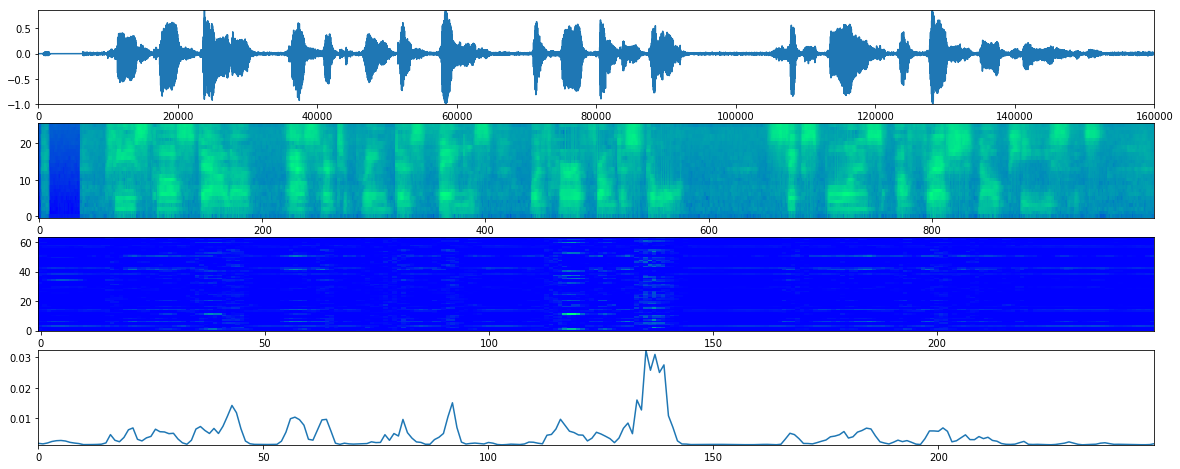

In [0]:
(rate,audio) = wav.read("data/%s.wav" % dev_dataset[dev_i][2])
audio = audio[0:rate*10]

f, axarr = plt.subplots(4, sharex=False, figsize=(20, 8))
axarr[0].plot(audio/np.max(np.abs(audio),axis=0))
axarr[0].margins(0)
axarr[1].imshow(dev_dataset[dev_i][0].numpy().T, origin="lower", aspect='auto', cmap=cm.winter)

axarr[2].imshow(x[0].detach().cpu().numpy().T, origin="lower", aspect='auto', cmap=cm.winter)

axarr[3].plot(att_s[0,:,0].detach().cpu().numpy())
axarr[3].margins(0)

In [0]:
ipd.Audio(audio, rate=rate)